## Coding Assignment 3

Team:
- Olivia Dalglish (od4)
- Arindam Saha (saha2)

Contribution: 

Olivia: Part 2 and 3

Arindam: Part 1 and 3

In addition to the above, we discussed our approaches and checked each other's work.

### Part I: Optimal Span for LOESS

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skmisc.loess import loess
from scipy.interpolate import splev
from sklearn.cluster import KMeans
from tqdm.notebook import trange


In [2]:
myData = pd.read_csv("Coding3_Data.csv")
var_names = myData.columns
y = myData[['y']].to_numpy().flatten()
x = myData[['x']].to_numpy()
len(x), len(y)

(30, 30)

In [3]:
def smoother_matrix_diag(x, span):
    model = loess(x, np.zeros(len(x)), span=span)
    model.fit()
    return model.outputs.diagonal


def optimal_span(x, y, spans):
    cv_values = np.zeros(len(spans))
    gcv_values = np.zeros(len(spans))
    for idx, span in enumerate(spans):
        model = loess(x, y, span=span)
        model.fit()
        y_hat = model.predict(x).values
        
        s_diag = smoother_matrix_diag(x, span)
        cv = np.mean(((y - y_hat) / (1 - s_diag)) ** 2)
        gcv = np.mean(((y - y_hat) / (1 - np.mean(s_diag))) ** 2)

        cv_values[idx] = cv
        gcv_values[idx] = gcv

    return cv_values, gcv_values, spans[np.argmin(cv_values)], spans[np.argmin(gcv_values)]
    
spans = np.linspace(0.20, 0.90, 15)    

cv_values, gcv_values, cv_best_span, gcv_best_span = optimal_span(x, y, spans)

for span, cv_value, gcv_value in zip(spans, cv_values, gcv_values):
    print(f"span: {span} cv_value: {cv_value} gcv_values: {gcv_value}")

print(f"best span: cv {cv_best_span} gcv {gcv_best_span}")



span: 0.2 cv_value: 12.415910699871809 gcv_values: 2.110161841942955
span: 0.25 cv_value: 2.2414734958901503 gcv_values: 1.4892056326217187
span: 0.3 cv_value: 1.5029798111583694 gcv_values: 1.1901098446318226
span: 0.35 cv_value: 1.2591747084691491 gcv_values: 1.1744229564766888
span: 0.4 cv_value: 1.1903799279913367 gcv_values: 1.102539903823101
span: 0.44999999999999996 cv_value: 1.1568121230625683 gcv_values: 1.0625034645069498
span: 0.5 cv_value: 1.1243056621273273 gcv_values: 1.0404222708825768
span: 0.55 cv_value: 1.179663752374441 gcv_values: 1.1188405514998327
span: 0.6 cv_value: 1.179464162542817 gcv_values: 1.1192688072551902
span: 0.6499999999999999 cv_value: 1.2509138273813036 gcv_values: 1.180584776931384
span: 0.7 cv_value: 1.553562264253347 gcv_values: 1.5190908128135594
span: 0.75 cv_value: 1.6361746170729456 gcv_values: 1.6274293455726156
span: 0.8 cv_value: 1.764533626604454 gcv_values: 1.7445490858435333
span: 0.8499999999999999 cv_value: 1.9760935148587322 gcv_valu

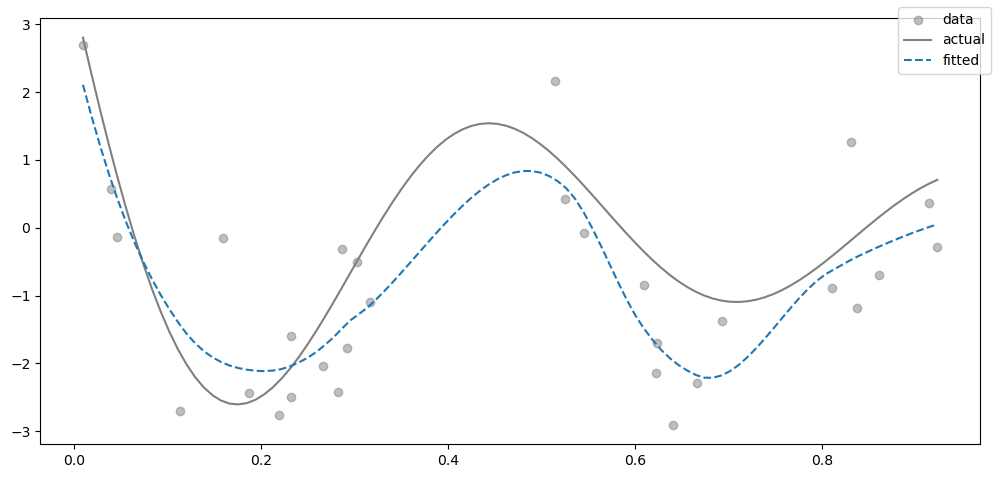

In [4]:
fig, axes = plt.subplots(nrows=1, ncols=1)

plot_x = np.linspace(np.min(x), np.max(x), 100)
smoothed = loess(x, y, span=cv_best_span).predict(plot_x).values

def actual_f(x):
    return np.sin(12 * (x + 0.2)) / (x + 0.2)

axes.scatter(x, y, marker='o', alpha=0.5, c='gray', label='data')
axes.plot(plot_x, actual_f(plot_x), c='gray', label='actual')
axes.plot(plot_x, smoothed, linestyle='--', label='fitted')
fig.set_figwidth(10)
fig.legend()
fig.tight_layout()
plt.show()

### Part II: Ridgeless and double descent

In [5]:
np.random.seed(1735)

##### Task 1: Ridgeless Function

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def ridgeless(train, test, d, threshold=1e-10):
    """
    Args:
        train: training data matrix
        test: test data matrix
        d: number of features (first d columns of feature data to use)
        threshold: threshold to use for filtering out singular values in SVD
    Returns:
        test_error
    """
    Y_train = train[:, 0]
    X_train = train[:, 1:d+1]

    Y_test = test[:, 0]
    X_test = test[:, 1:d+1]

    # center the features
    X_mean = np.mean(X_train, axis=0)
    X_train_centered = X_train - X_mean
    X_test_centered = X_test - X_mean

    # SVD decomposition
    U, S, Vt = np.linalg.svd(X_train_centered, full_matrices=False)

    S_inv = np.array([1/s if s > threshold else 0 for s in S]) # filter out small eigenvalues
    beta = Vt.T @ np.diag(S_inv) @ U.T @ Y_train

    Y_test_pred = X_test_centered @ beta
    test_error = np.mean((Y_test - Y_test_pred) ** 2)

    return test_error

##### Task 2: Simulation study

  0%|          | 0/30 [00:00<?, ?it/s]

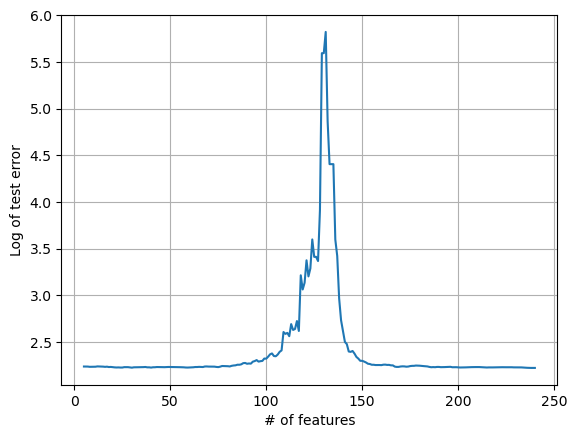

In [7]:
data = np.loadtxt('Coding3_dataH.csv', delimiter=',')

num_iterations = 30
n_samples, n_features = data.shape
num_d = 236
test_errors_matrix = np.zeros((num_iterations, num_d))

for i in trange(num_iterations):
    np.random.shuffle(data)
    train_size = int(0.25 * n_samples)
    train_data = data[:train_size, :]
    test_data = data[train_size:, :]

    for d in range(6, 242):
        test_error = ridgeless(train_data, test_data, d)
        test_errors_matrix[i, d-6] = np.log(test_error)

median_test_errors = np.median(test_errors_matrix, axis=0)

plt.plot(range(5, 241), median_test_errors)
plt.xlabel('# of features')
plt.ylabel('Log of test error')
plt.grid(True)
plt.show()

### Part III: Clustering time series

In [8]:
np.random.seed(1735)

In [9]:
data = pd.read_csv('Sales_Transactions_Dataset_Weekly.csv')

week_cols = [f'W{idx}' for idx in range(52)]
data = data[week_cols].to_numpy()

means = np.mean(data, axis=1, keepdims=True)
X = data - means

##### Task 1: Fitting NCS

In [10]:
# Copied code from https://liangfgithub.github.io/Python_W5_RegressionSpline.html

# converted from R's ns()
def ns(x, df=None, knots=None, boundary_knots=None, include_intercept=False):
    degree = 3
    
    if boundary_knots is None:
        boundary_knots = [np.min(x), np.max(x)]
    else:
        boundary_knots = np.sort(boundary_knots).tolist()

    oleft = x < boundary_knots[0]
    oright = x > boundary_knots[1]
    outside = oleft | oright
    inside = ~outside

    if df is not None:
        nIknots = df - 1 - include_intercept
        if nIknots < 0:
            nIknots = 0
            
        if nIknots > 0:
            knots = np.linspace(0, 1, num=nIknots + 2)[1:-1]
            knots = np.quantile(x[~outside], knots)

    Aknots = np.sort(np.concatenate((boundary_knots * 4, knots)))
    n_bases = len(Aknots) - (degree + 1)

    if any(outside):
        basis = np.empty((x.shape[0], n_bases), dtype=float)
        e = 1 / 4 # in theory anything in (0, 1); was (implicitly) 0 in R <= 3.2.2

        if any(oleft):
            k_pivot = boundary_knots[0]
            xl = x[oleft] - k_pivot
            xl = np.c_[np.ones(xl.shape[0]), xl]

            # equivalent to splineDesign(Aknots, rep(k.pivot, ord), ord, derivs)
            tt = np.empty((xl.shape[1], n_bases), dtype=float)
            for j in range(xl.shape[1]):
                for i in range(n_bases):
                    coefs = np.zeros((n_bases,))
                    coefs[i] = 1
                    tt[j, i] = splev(k_pivot, (Aknots, coefs, degree), der=j)

            basis[oleft, :] = xl @ tt

        if any(oright):
            k_pivot = boundary_knots[1]
            xr = x[oright] - k_pivot
            xr = np.c_[np.ones(xr.shape[0]), xr]

            tt = np.empty((xr.shape[1], n_bases), dtype=float)
            for j in range(xr.shape[1]):
                for i in range(n_bases):
                    coefs = np.zeros((n_bases,))
                    coefs[i] = 1
                    tt[j, i] = splev(k_pivot, (Aknots, coefs, degree), der=j)
                    
            basis[oright, :] = xr @ tt
        
        if any(inside):
            xi = x[inside]
            tt = np.empty((len(xi), n_bases), dtype=float)
            for i in range(n_bases):
                coefs = np.zeros((n_bases,))
                coefs[i] = 1
                tt[:, i] = splev(xi, (Aknots, coefs, degree))

            basis[inside, :] = tt
    else:
        basis = np.empty((x.shape[0], n_bases), dtype=float)
        for i in range(n_bases):
            coefs = np.zeros((n_bases,))
            coefs[i] = 1
            basis[:, i] = splev(x, (Aknots, coefs, degree))

    const = np.empty((2, n_bases), dtype=float)
    for i in range(n_bases):
        coefs = np.zeros((n_bases,))
        coefs[i] = 1
        const[:, i] = splev(boundary_knots, (Aknots, coefs, degree), der=2)

    if include_intercept is False:
        basis = basis[:, 1:]
        const = const[:, 1:]

    qr_const = np.linalg.qr(const.T, mode='complete')[0]
    basis = (qr_const.T @ basis.T).T[:, 2:]

    return basis

In [11]:
F = ns(np.arange(52), df=9, include_intercept=False)
F = F - np.mean(F, axis=0)
F.shape

(52, 9)

In [12]:
B = (np.linalg.inv(F.T @ F) @ F.T @ X.T).T
B.shape

(811, 9)

##### Task 2: Cluster Matrix B

In [13]:
def plot_clusters(X, labels, centers, nrows, ncols):
    assert 0 <= np.min(labels)
    assert np.max(labels) < nrows * ncols
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols)

    y_lim = np.array([np.min(X), np.max(X)])

    for row in range(nrows):
        for col in range(ncols):
            label = (row * ncols) + col
            idxs = np.where(labels == label)[0]
            
            axes[row, col].plot(np.arange(52), X[idxs].T, c='lightgray')
            axes[row, col].plot(np.arange(52), centers[label], c='red')
            
            axes[row, col].set_xlabel('Weeks')
            axes[row, col].set_ylabel('Weeky Sales')
            
            axes[row, col].set_xlim([0, 52])
            axes[row, col].set_ylim(y_lim)

    fig.set_figwidth(15)
    fig.set_figheight(10)
    plt.show()


def get_centers(X, labels):
    return np.array([np.mean(X[np.where(labels == label)[0]], axis=0) for label in range(6)])


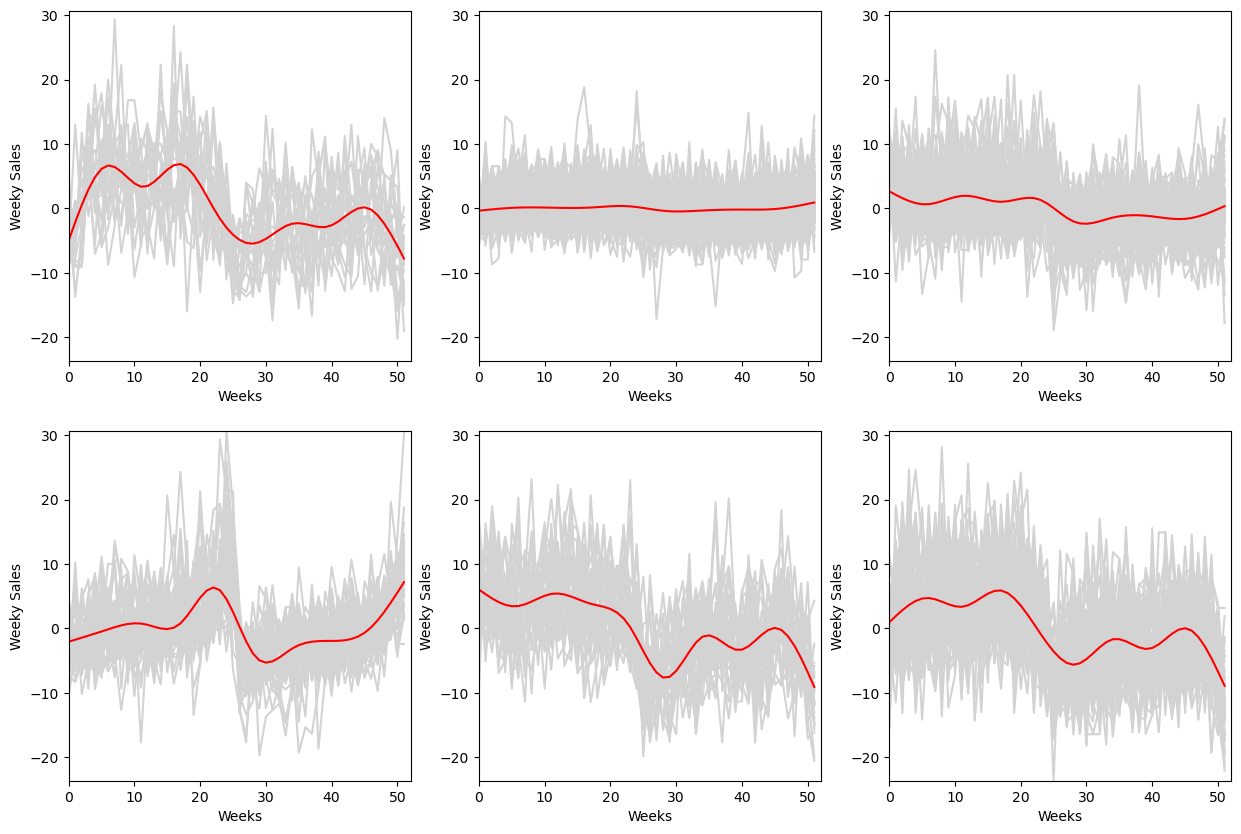

In [14]:
km_b = KMeans(n_clusters=6, n_init=10).fit(B)
centers = get_centers(B, km_b.labels_)
centers = (F @ centers.T).T
plot_clusters(X, km_b.labels_, centers, 2, 3)


##### Task 3: Cluster Matrix X

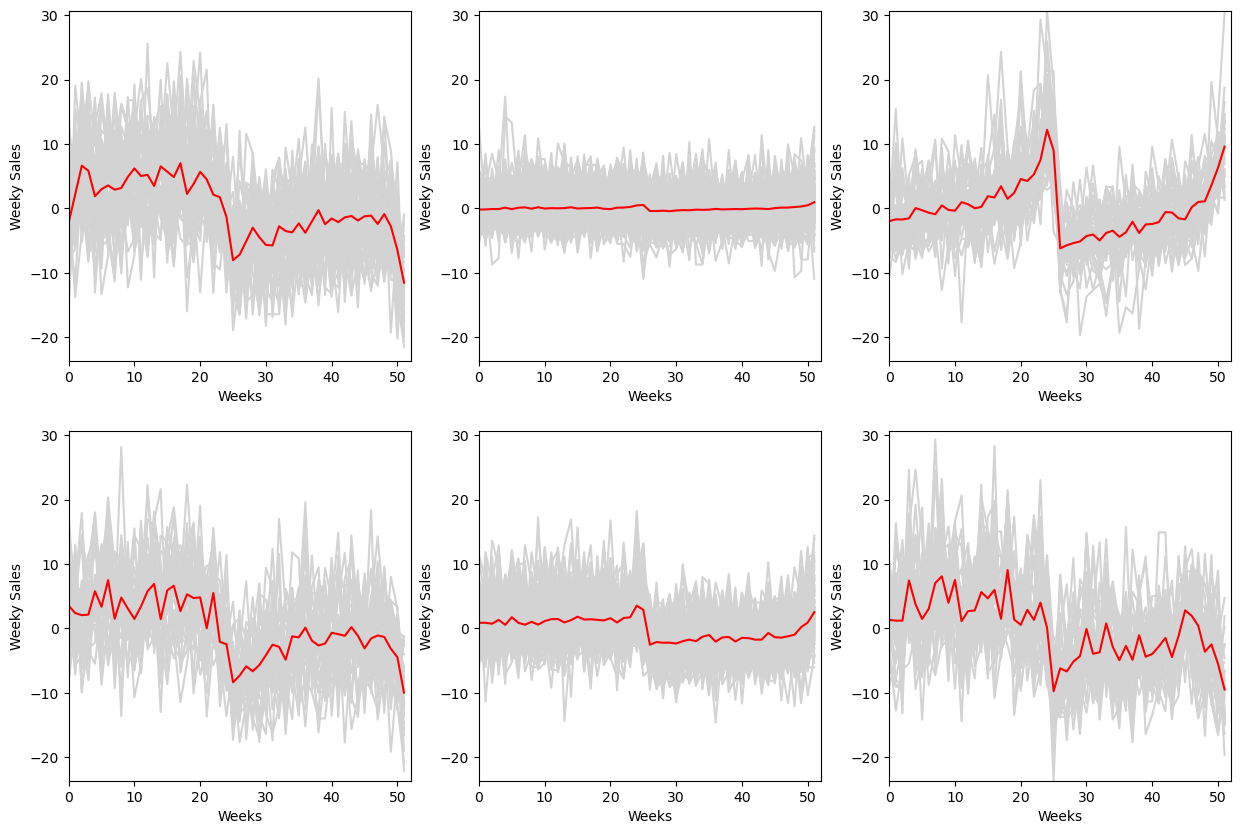

In [15]:
km_x = KMeans(n_clusters=6, n_init=10).fit(X)
centers = get_centers(X, km_x.labels_)
plot_clusters(X, km_x.labels_, centers, 2, 3)

The cluster centers derived from Task 2 are indeed smoother than those from Task 3.